In [1]:
%matplotlib inline
import os
import sys
AbsPath = str(os.path.abspath(""))+"/../.."
sys.path.append(AbsPath)
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import cm
ColourMap = cm.RdBu
from astropy.io import fits
from astropy.table import table
import pandas as pd
import numpy as np
from Scripts.Plots import SDSS_Plots
import pickle
import hmf
from Functions import Functions as F
import scipy
from itertools import cycle
from copy import copy
from scipy import interpolate
from astropy.cosmology import Planck15 as cosmo_ap
from astropy import units as u
from colossus.cosmology import cosmology
import colossus.halo.mass_adv as massdefs
cosmology.setCosmology("planck15")
Cosmo = cosmology.getCurrent()
#set plot paramaters here
mpl.rcParams.update(mpl.rcParamsDefault)
Add_SDSS = SDSS_Plots.SDSS_Plots(11.5,15,0.1) #pass this halomass:min, max, and binwidth for amting the SDSS plots
#gets the HMF interpolation function
HMF_fun = F.Make_HMF_Interp() #N Mpc^-3 h^3 dex^-1
h = Cosmo.h
h_3 = h*h*h

/Users/haofu/.conda/envs/STEEL/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


FRACKSKY= 0.1404020420493216


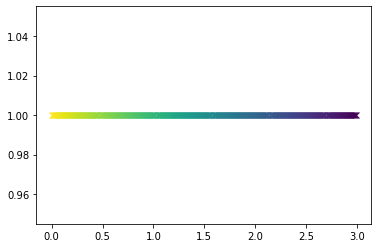

In [3]:
ColourMap = cm.viridis_r
def GetColour(z):
    return ColourMap(float((z/3)))

for i in np.arange(0, 3, 0.01):
    plt.plot(i, 1,"x", color = GetColour(i))
plt.show()    

In [5]:
#set plot paramaters here
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['axes.linewidth']=2
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
mpl.rcParams['axes.titlepad'] = 20
plt.rcParams['font.size']=15

In [4]:
#Abundance Matching Parameters
Override =\
{\
'M10':12.0,\
'SHMnorm10':0.032,\
'beta10':1.5,\
'gamma10':0.56,\
'M11':0.6,\
'SHMnorm11':-0.014,\
'beta11':-2,\
'gamma11':0.08\
}


AbnMtch =\
{\
'Behroozi13': False,\
'Behroozi18': False,\
'B18c':False,\
'B18t':False,\
'G18':False,\
'G18_notSE':False,\
'G19_SE':False,\
'G19_cMod':False,\
'Lorenzo18':False,\
'Moster': False,\
'Moster10': False,\
'Illustris': False,\
'z_Evo':True,\
'Scatter': 0.15,\
'Override_0': False,\
'Override_z': False,\
'Override': Override,\
'PFT': False,\
'M_PFT1': False,\
'M_PFT2': False,\
'M_PFT3': False,\
'N_PFT1': False,\
'N_PFT2': False,\
'N_PFT3': False,\
'b_PFT1': False,\
'b_PFT2': False,\
'b_PFT3': False,\
'g_PFT1': False,\
'g_PFT2': False,\
'g_PFT3': False,\
'g_PFT4': False\
}

Paramaters = \
{\
'AbnMtch' : AbnMtch,\
'AltDynamicalTime': 1,\
'NormRnd': 0.5,\
'SFR_Model': 'CE',\
'PreProcessing': False,\
'AltDynamicalTimeB': False\
}

In [ ]:
#This cell imports and sorts the zCOSMOS data


In [19]:
#This cell loads the Wen Data
def CMD_wrap(M, z):
    return np.log10((massdefs.changeMassDefinitionCModel(M=M*0.7, z=z, mdef_in='500c', mdef_out='vir')[0])/Cosmo.h)

Header = ['Name','RA','Dec','z','i_bcg','W1_bcg','SNR','r','L','R_l','M','N','Other']
z_bins = [0.6, 0.8, 1.0]
hm_bins = [14.5, 14.75, 15, 15.25, 15.5]
Data_Clus = pd.read_csv(AbsPath+"/Data/Observational/Clusters1959/table1.dat", header = None, names = Header, sep=r"[ ]{2,}")
Data_Clus['mvir'] = np.vectorize(CMD_wrap)((np.array(Data_Clus.M)*(10**14)), np.array(Data_Clus.z))
Data_Clus = Data_Clus.assign(Bin_z=lambda x: pd.cut(x.z, bins=z_bins)).assign(Bin_m=lambda x: pd.cut(x.mvir, bins=hm_bins))

#for the Clusters
Header = ['ID','RA','Dec','z','mag_r', 'mag_i', 'mag_W1','SNR','r500','richness', 'N']
Data_Clus_2 = pd.read_csv(AbsPath+"/Data/Observational/Clusters1959/cluster_wh18.dat", header = None, names = Header, sep=r"[ ]{2,}", skiprows = 1)

def FindID(ra, dec, Table = Data_Clus_2):
    ra_match = Table[np.isclose(np.array(Table.RA), ra, rtol=1e-04, atol=1e-08)]
    dec_match = ra_match[np.isclose(np.array(ra_match.Dec), dec, rtol=1e-04, atol=1e-08)]
    if len(dec_match.ID) == 1:
        return dec_match.ID
    else:
        return -1
#Adds the cluster ID to the publised table to allow for comparision with DataMem
Data_Clus['ID'] = np.vectorize(FindID)(np.array(Data_Clus.RA), np.array(Data_Clus.Dec))

#For the members
Header = ['ID','RA','Dec','z','mag_r', 'mag_i', 'mag_W1','distance_to_clus_cent']
Data_Mem = pd.read_csv(AbsPath+"/Data/Observational/Clusters1959/member_cand.dat", header = None, names = Header, sep=r"[ ]{1,}", skiprows = 1)

def Get_ClusZ(Cluster_ID, Table = Data_Clus):
    Redshift = Table.loc[Table.ID == Cluster_ID].z
    if len(Redshift) == 1:
        return Redshift
    else:
        return -1

def W1_to_Mass(W1, z):
    #Masses returned are using Chabrier IMF 2003 using MPA-JHU see Kauffmann 2003
    v= (3*(10**8))/((38723.88-2754.97)*(10**-10))  #width of bandpass in frequency units #http://svo2.cab.inta-csic.es/svo/theory/fps/index.php?id=WISE/WISE.W1&&mode=browse&gname=WISE&gname2=WISE#filter
    L_sun = (3.8*(10**26)) #watts
    
    
    Fv = 309.540*np.power(10, -(W1-2.699)/2.5) #Source flux density in Jansky #http://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html#conv2flux
    #if v:
    #    print("Source flux density", Fv, "[Jy]")
    dL = cosmo_ap.luminosity_distance(z).to(u.m).value #astropy
    #if v:
    #    print("Luminisoty Distance", dL, "[m]")
    Lv = 4*np.pi*np.power(dL, 2)*Fv*(10**-26) #M. Childress
    #if v:
    #    print("Source Luminosity  ", Lv, "[Watts]")
    M = -0.40+1.120*np.log10(v*Lv/L_sun) #https://academic.oup.com/mnras/article/433/4/2946/1749049
    #if v:
    #    print("Mass", M, "log10 [Msun]")
    return M
    
Data_Mem["Cluster_z"] = np.vectorize(Get_ClusZ)(np.array(Data_Mem.ID))
Data_Mem["M_star"] = np.vectorize(W1_to_Mass)(np.array(Data_Mem.mag_W1), np.array(Data_Mem.Cluster_z))


def SatCuts(ID, Flag, Cluster_Gals = Data_Mem):
    Member_Mass = Cluster_Gals.loc[Cluster_Gals.ID == ID].M_star +0.15 #0.15 added here to convert from Bruzal and Charlot to Meert    
    if Flag == 'a':
        N = np.sum(np.array(Member_Mass) > 10)
    if Flag == 'b':
        N = np.sum(np.array(Member_Mass) > 10.5)
    if Flag == 'c': 
        N = np.sum(np.array(Member_Mass) > 11)
    #Remove Central
    if N > 0:
        N = N-1
    return N

Data_Clus['Ngal_ten'] = np.vectorize(SatCuts)(np.array(Data_Clus.ID), "a")
Data_Clus['Ngal_tpf'] = np.vectorize(SatCuts)(np.array(Data_Clus.ID), "b")
Data_Clus['Ngal_ele'] = np.vectorize(SatCuts)(np.array(Data_Clus.ID), "c")

/home/pg1g15/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
/home/pg1g15/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
/home/pg1g15/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [160]:
def Frac_Plot_HZ(PltName, Tdyn_Factors):
    mpl.rcParams.update({'lines.markersize': 9})
    mpl.rcParams.update({'lines.linewidth': 1.5})
    AvaHaloMass, z, AnalyticalModelFrac_highz, AnalyticalModelNoFrac_highz, SM_Cuts = F.LoadData_Sat_Env_Highz(Tdyn_Factors)  
    SM_Cuts_Plt = [10.0, 10.5, 11] # use this to pick SM_Cut to plot
    
    AvaHaloMassBins = AvaHaloMass[:,1:] - AvaHaloMass[:,:-1] 
    AvaHaloMassBins = np.concatenate((AvaHaloMassBins, np.array([AvaHaloMassBins[:,-1]]).T), axis = 1)
    
    #DynamicalTime NoFrac=======================================================
    fig = plt.figure(figsize=[12, 4])
    gs = GridSpec(4, 13, hspace=0.0,wspace=0.0,figure=fig)
    ax1 = fig.add_subplot(gs[0:4, 0:4])
    ax2 = fig.add_subplot(gs[0:4, 4:8])
    ax3 = fig.add_subplot(gs[0:4, 8:12])
    ColorBar = fig.add_subplot(gs[0:4, 12:13])
    SubPlots_NF = [ax1,ax2,ax3]
    #f_NF, SubPlots_NF = plt.subplots(1, len(SM_Cuts_Plt), figsize = (13,4), sharey = True)
    PltName = "HighzClusters"
       
    Redshifts = []
    #Adding Wen
    for z_group in Data_Clus.groupby(['Bin_z']):
        z_ = round(z_group[0].mid, 2)
        colour = GetColour(z_)
        for hm_group in z_group[1].groupby(['Bin_m']):
            hm = round(hm_group[0].mid, 2)
            HM_wt = HMF_fun(hm+np.log10(h), z_)[0]*hm_group[0].length*h_3
            
            Sat_wt = np.log10(HM_wt*np.mean(hm_group[1]['Ngal_ten'])/hm_group[0].length)
            SubPlots_NF[0].plot(hm, Sat_wt, '^', color = colour, fillstyle = "none")
            Sat_wt = np.log10(HM_wt*np.mean(hm_group[1]['Ngal_tpf'])/hm_group[0].length)
            SubPlots_NF[1].plot(hm, Sat_wt, '^', color = colour, fillstyle = "none")
            Sat_wt = np.log10(HM_wt*np.mean(hm_group[1]['Ngal_ele'])/hm_group[0].length)
            SubPlots_NF[2].plot(hm, Sat_wt, '^', color = colour, fillstyle = "none")
        Redshifts.append(z_)
    
    
    #Adding Marc HC COSMOS
    File = fits.open(AbsPath+"/Data/Observational/M_HC_COSMOS/COSMOS_forFrancesco.fit")
    df = table.Table(File[1].data).to_pandas()
    df.HMASS = (df.HMASS-np.log10(0.72))+np.log10(h) #h correction
    df['mvir'] = np.vectorize(CMD_wrap)(np.power(10, df.HMASS), np.array(df.ZPHOT)) #200c to vir correction

    df.MSTAR = df.MSTAR -np.log10(0.72) + np.log10(h) + 0.15 #h correction and bruzual and charlot correction
    df_cen = df[df.CENTRAL == 1].copy()
    df_sat = df[df.CENTRAL == 0].copy()
    df_sat = df_sat[df_sat.HMASS>0].copy()

    def Get_Sat_Rich(M_Central_Halo, M_Central_Gal, M_Cut):
        Table = df_sat[df_sat.HMASS == M_Central_Halo]
        N = len(Table[Table.MSTAR > M_Cut])
        if np.any(Table.MSTAR > M_Central_Gal) and (M_Central_Gal < M_Cut):
            return N - 1
        else:
            return N 

    def Get_Sat_Mass(M_Central):
        Table = df_sat[df_sat.HMASS == M_Central]
        M = np.sum(np.power(10, Table.MSTAR))
        return np.log10(M)
    def Get_MaxSat_Mass(M_Central):    
        Table = df_sat[df_sat.HMASS == M_Central]
        return np.max(Table.MSTAR)


    df_cen['NSat_ten'] = np.vectorize(Get_Sat_Rich)(np.array(df_cen.HMASS), np.array(df_cen.MSTAR), 10)
    df_cen['NSat_tpf'] = np.vectorize(Get_Sat_Rich)(np.array(df_cen.HMASS), np.array(df_cen.MSTAR), 10.5)
    df_cen['NSat_ele'] = np.vectorize(Get_Sat_Rich)(np.array(df_cen.HMASS), np.array(df_cen.MSTAR), 11)
    df_cen['Total_Sat_Mass'] = np.vectorize(Get_Sat_Mass)(np.array(df_cen.HMASS))
    df_cen['Max_Sat_Mass'] = np.vectorize(Get_MaxSat_Mass)(np.array(df_cen.HMASS))
    hm_bins = np.arange(13, 15.5, 0.3)
    z_bins = [0.0, 0.3, 0.7, 1.0, 1.5, 2.0]
    df_cen = df_cen.assign(Bin_z=lambda x: pd.cut(x.ZPHOT, bins=z_bins)).assign(Bin_m=lambda x: pd.cut(x.mvir, bins=hm_bins))

    for z_group in df_cen.groupby(['Bin_z']):
        z_ = round(z_group[0].mid, 2)
        colour = GetColour(z_)
        for hm_group in z_group[1].groupby(['Bin_m']):
            hm = round(hm_group[0].mid, 2)
            HM_wt = HMF_fun(hm+np.log10(h), z_)[0]*hm_group[0].length*h_3
            #print(hm_group)
            Sat_wt = np.log10(HM_wt*np.mean(hm_group[1]['NSat_ten'])/hm_group[0].length)
            SubPlots_NF[0].plot(hm, Sat_wt, 'H', color = colour, fillstyle = "none")
            Sat_wt = np.log10(HM_wt*np.mean(hm_group[1]['NSat_tpf'])/hm_group[0].length)
            SubPlots_NF[1].plot(hm, Sat_wt, 'H', color = colour, fillstyle = "none")
            Sat_wt = np.log10(HM_wt*np.mean(hm_group[1]['NSat_ele'])/hm_group[0].length)
            SubPlots_NF[2].plot(hm, Sat_wt, 'H', color = colour, fillstyle = "none")
        Redshifts.append(z_)
    
    
    #Adding Wang
    #Stellar_Masses_Sal = np.array([10.82,10.19,10.77,11.03,10.38,10.68,11.26,11.12,11.06,11.58,11.29,11.57,11.16,11.36,11.13,10.90,11])
    Stellar_Masses_Sal = np.array([10.82,10.19,10.77,11.03,10.38,10.68,11.26,11.12,11.06,11.29,11.57,11.16,11.36,11.13,10.90,11]) #removed largest galaxy or 'central''
    Stellar_Masses_Chab = Stellar_Masses_Sal - 0.24
    
    HaloVirMass = np.log10((massdefs.changeMassDefinitionCModel(M=np.power(10, 13.9)*0.7, z=2.506, mdef_in='200c', mdef_out='vir')[0])/Cosmo.h)                                                
    x_values = np.arange(HaloVirMass, 18, 0.1)
    HMF = HMF_fun(x_values+np.log10(h), 2.506)
    ClusterAbn = np.log10(scipy.integrate.trapz(HMF, x = x_values)) + np.log10(h_3)
    
    colour = GetColour(2.5)
    
    Count = np.count_nonzero(Stellar_Masses_Chab > 10)
    RtCount = np.sqrt(Count)
    Count_ul = np.array([Count + np.sqrt(Count), Count - np.sqrt(Count)])
    SubPlots_NF[0].errorbar([HaloVirMass],[ClusterAbn+np.log10(Count)], yerr = [np.log10(Count_ul) - np.log10(Count)], color = colour, fmt = "o", mfc = None, fillstyle = "none")
    Count = np.count_nonzero(Stellar_Masses_Chab > 10.5)
    RtCount = np.sqrt(Count)
    Count_ul = np.array([Count + np.sqrt(Count), Count - np.sqrt(Count)])
    SubPlots_NF[1].errorbar([HaloVirMass],[ClusterAbn+np.log10(Count)], yerr = [np.log10(Count_ul) - np.log10(Count)], color = colour, fmt = "o", mfc = None, fillstyle = "none")
    Count = np.count_nonzero(Stellar_Masses_Chab > 11)
    RtCount = np.sqrt(Count)
    Count_ul = np.array([Count + np.sqrt(Count), Count - np.sqrt(Count)])
    SubPlots_NF[2].errorbar([HaloVirMass],[ClusterAbn+np.log10(Count)], yerr = [np.log10(Count_ul) - np.log10(Count)], color = colour, fmt = "o", mfc = None, fillstyle = "none")
    
    Redshifts.append(2.5)
    
    #adding illustris
    Vol=(100/0.7)**3
    for ill_snap in os.listdir(AbsPath+"/Data/Observational/Illustris_Cats/"):
        df = pd.read_csv(AbsPath+"/Data/Observational/Illustris_Cats/{}".format(ill_snap))
        df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
        centrals_index = df.groupby('GrpID')['SubDM'].transform(max) == df['SubDM']
        centrals = df[centrals_index]
        sat = df[np.logical_not(centrals_index)]
        
        colour = GetColour(float(ill_snap[2:-4]))
        
        df_10 = sat[sat['SatSM'] -np.log10(h)>10]
        df_10p5 = sat[sat['SatSM'] -np.log10(h)>10.5]
        df_11 = sat[sat['SatSM'] -np.log10(h)>11]
        HM_bin = 0.4
        Vol=(110.72)**3 #From Illustris Jupyterlab workspace Data['header']['BoxSize']/Data['header']['HubbleParam']/10**3
        HM_Bins = np.arange(11, 16, HM_bin)
        y,x = np.histogram(df_10['ParentDM']-np.log10(h), bins = HM_Bins)
        SubPlots_NF[0].plot(np.divide(x[1:]+x[:-1], 2), np.log10(y/(HM_bin*Vol)),"x", color = colour, mfc = None, fillstyle = "none")
        y,x = np.histogram(df_10p5['ParentDM']-np.log10(h), bins = HM_Bins)
        SubPlots_NF[1].plot(np.divide(x[1:]+x[:-1], 2), np.log10(y/(HM_bin*Vol)),"x", color = colour, mfc = None, fillstyle = "none")
        y,x = np.histogram(df_11['ParentDM']-np.log10(h), bins = HM_Bins)
        SubPlots_NF[2].plot(np.divide(x[1:]+x[:-1], 2), np.log10(y/(HM_bin*Vol)),"x", color = colour, mfc = None, fillstyle = "none")
        
        Redshifts.append(float(ill_snap[2:-4]))
    
    Redshifts.sort()
    NewRedshifts = []
    Skip = False
    for i in range(len(Redshifts)-1):
        if Skip:
            Skip = False
        else:
            if (Redshifts[i+1] - Redshifts[i])/np.divide(Redshifts[i+1] + Redshifts[i],2) > 0.1:
                NewRedshifts.append(Redshifts[i])
            else:
                NewRedshifts.append(np.divide(Redshifts[i+1] + Redshifts[i],2))
                Skip = True
        NewRedshifts.append(Redshifts[-1])        
    
    
    Redshift_Bins = np.digitize(NewRedshifts, bins = z)
    for j, Cut in enumerate(SM_Cuts_Plt):
        SubPlots_NF[j].set_title("$M_{*, sat} > 10^{%s}$" %(Cut))
        X_SDSS, Y_SDSS = Add_SDSS.NoFracPlot(SubPlots_NF[j], SM_Cut = Cut)
        for i, z_ in enumerate(z):
            if np.any(i == Redshift_Bins):
                Data_ix = np.digitize(Cut, bins = SM_Cuts)-1
                X_Bin = np.digitize(X_SDSS[0], AvaHaloMass[i]- np.log10(h))
                Y_Model = np.divide(AnalyticalModelNoFrac_highz[Data_ix][i], AvaHaloMassBins[i])
                X, Y = F.Gauss_Scatt(AvaHaloMass[i, X_Bin:]- np.log10(h), Y_Model[X_Bin:], Scatt = 0.1)
           
                SubPlots_NF[j].plot(X-0.1, np.log10(Y), "-", color =  GetColour(z_))

    SubPlots_NF[0].set_ylim(-8, -3)
    SubPlots_NF[1].set_ylim(-8, -3)
    SubPlots_NF[2].set_ylim(-8, -3)
    SubPlots_NF[0].set_xlim(11.5, 15.5)
    SubPlots_NF[1].set_xlim(11.5, 15.5)
    SubPlots_NF[2].set_xlim(11.5, 15.5)
    SubPlots_NF[1].axes.get_yaxis().set_ticklabels([])
    SubPlots_NF[2].axes.get_yaxis().set_ticklabels([])
    #SubPlots_NF[1].yaxis.set_visible(False)
    #SubPlots_NF[2].yaxis.set_visible(False)
    ColorBar.xaxis.set_visible(False)
    
    for i in np.arange(0.0, 3.0, 0.01):
        ColorBar.fill_between([-0.5, 1.5], i, i+0.01, color = GetColour(i))
    ColorBar.set_ylim(0, 3)
    ColorBar.set_xlim(0, 1)
    ColorBar.yaxis.tick_right()
    ColorBar.yaxis.set_label_position("right")
    ColorBar.set_ylabel("Redshift")
        
    #sneaky points for labels
    SubPlots_NF[1].fill_between([0,0.1], 0, 0.1, alpha = 0.5, color = 'tab:gray', label = "SDSS") #sneaky point for label
    SubPlots_NF[1].plot(0, 0, '^', color = "k", label = "Wen & Han 2018", fillstyle = "none") #sneaky point for label
    SubPlots_NF[1].plot(0, 0, 'x', color = "k", label = "Illustris", fillstyle = "none") #sneaky point for label
    SubPlots_NF[1].plot(0, 0, "o", color = "k", label = "Wang et al 2016", fillstyle = "none") #sneaky point for label
    SubPlots_NF[1].plot(0, 0, '-', color = "k", label = "STEEL", fillstyle = "none") #sneaky point for label
    lgd_NF = SubPlots_NF[1].legend(loc = 8, frameon = False, ncol = 3, bbox_to_anchor=(0.5, -0.5))
    
    SubPlots_NF[1].set_xlabel("$log_{10}$ $M_h$ [$M_\odot$]", fontproperties = mpl.font_manager.FontProperties(size = 13))
    SubPlots_NF[0].set_ylabel("$log_{10} \phi$ $[Mpc^{-3} dex^{-1}]$", fontproperties = mpl.font_manager.FontProperties(size = 13))
    fig.tight_layout()
    fig.savefig(AbsPath+"/Figures/Paper2/{}.png".format(PltName), bbox_extra_artists=(lgd_NF,), bbox_inches='tight')
    fig.savefig(AbsPath+"/Figures/Paper2/{}.pdf".format(PltName), bbox_extra_artists=(lgd_NF,), bbox_inches='tight')
    fig.clf()
    
    #===========================================================================
    
    mpl.rcParams.update({'font.size': 13}) 

In [164]:
#Frac_Plot_HZ("eh", ('1.0', True, True, True, 'G19_DPL', 'G19_SE'))#('1.0', True, True, True, 'CE', 'G19_SE'))
Frac_Plot_HZ("eh", ('1.0', True, False, True, 'Illustris', 'Illustris'))

/home/pg1g15/anaconda3/lib/python3.6/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


<Figure size 1200x400 with 0 Axes>

In [ ]:
HaloVirMass = np.log10((massdefs.changeMassDefinitionCModel(M=np.power(10, 13.7)*0.7, z=2.506, mdef_in='200c', mdef_out='vir')[0])/Cosmo.h)                                                
x_values = np.arange(HaloVirMass, 18, 0.1)
HMF = HMF_fun(x_values+np.log10(h), 2.506)
ClusterAbn = np.log10(scipy.integrate.trapz(HMF, x = x_values)) + np.log10(h_3)

print(HaloVirMass, ClusterAbn)
plt.plot(np.arange(11, 14.5, 0.1), np.log10(HMF_fun(np.arange(11, 14.5, 0.1), 2.5)*h_3))
plt.plot(HaloVirMass, ClusterAbn, "x")
plt.show()


In [ ]:
import importlib
importlib.reload(F)

In [ ]:
AbnMtch["G19_SE"] = True

Stellar_Masses_Sal = np.array([10.82,10.19,10.77,11.03,10.38,10.68,11.26,11.12,11.06,11.29,11.57,11.16,11.36,11.13,10.90,11]) #removed largest galaxy or 'central''
Stellar_Masses_Chab = Stellar_Masses_Sal - 0.24

HaloVirMass = np.log10((massdefs.changeMassDefinitionCModel(M=np.power(10, 13.9)*0.7, z=2.506, mdef_in='200c', mdef_out='vir')[0])/Cosmo.h)                                                
x_values = np.arange(HaloVirMass, 18, 0.1)
HMF = HMF_fun(x_values+np.log10(h), 2.506)
ClusterAbn = np.log10(scipy.integrate.trapz(HMF, x = x_values)) + np.log10(h_3)

z, SatHaloMass, AvaHaloMass, Surviving_Sat_SMF_MassRange, Sat_SMHM, Sat_SMHM_Host = F.LoadData_Sat_SMHM(('1.0', True, False, True, 'CE', 'G19_cMod'))
mpl.rcParams.update({'lines.markersize': 5})
mpl.rcParams.update({'lines.linewidth': 1.5})
z_bin = np.digitize(2.5, bins = z)
NoFrac_2pt5 = Sat_SMHM_Host[z_bin]
SM_Bin = Surviving_Sat_SMF_MassRange[1] - Surviving_Sat_SMF_MassRange[0]
SM_Cut = np.digitize(11.0, bins = Surviving_Sat_SMF_MassRange)
AvaHaloMassBins = AvaHaloMass[:,1:] - AvaHaloMass[:,:-1] 
AvaHaloMassBins = np.concatenate((AvaHaloMassBins, np.array([AvaHaloMassBins[:,-1]]).T), axis = 1)
Tot_SM = []
for i, sSMF in enumerate(NoFrac_2pt5[1:,SM_Cut:]):
    Central_Weight = HMF_fun(AvaHaloMass[z_bin,i], z[z_bin])*h_3*AvaHaloMassBins[z_bin, i]
    A1 = []
    Integrated_Mass = np.sum([ ((Wt/SM_Bin)*np.power(10, Surviving_Sat_SMF_MassRange[j]))/Central_Weight for j, Wt in enumerate(sSMF)])  
    Tot_SM.append(Integrated_Mass)


#plt.plot(AvaHaloMass[z_bin], F.DarkMatterToStellarMass(AvaHaloMass[z_bin], z[z_bin], Paramaters))
plt.plot(AvaHaloMass[z_bin], np.log10(Tot_SM+ np.power(10,F.DarkMatterToStellarMass(AvaHaloMass[z_bin], z[z_bin], Paramaters))), label = "STEEL_cMod" )

z, SatHaloMass, AvaHaloMass, Surviving_Sat_SMF_MassRange, Sat_SMHM, Sat_SMHM_Host = F.LoadData_Sat_SMHM(('1.0', True, True, True, 'G19_DPL', 'G19_SE'))
mpl.rcParams.update({'lines.markersize': 5})
mpl.rcParams.update({'lines.linewidth': 1.5})
z_bin = np.digitize(2.5, bins = z)
NoFrac_2pt5 = Sat_SMHM_Host[z_bin]
SM_Bin = Surviving_Sat_SMF_MassRange[1] - Surviving_Sat_SMF_MassRange[0]
SM_Cut = np.digitize(11.0, bins = Surviving_Sat_SMF_MassRange)
AvaHaloMassBins = AvaHaloMass[:,1:] - AvaHaloMass[:,:-1] 
AvaHaloMassBins = np.concatenate((AvaHaloMassBins, np.array([AvaHaloMassBins[:,-1]]).T), axis = 1)
Tot_SM = []
for i, sSMF in enumerate(NoFrac_2pt5[1:,SM_Cut:]):
    Central_Weight = HMF_fun(AvaHaloMass[z_bin,i], z[z_bin])*h_3*AvaHaloMassBins[z_bin, i]
    A1 = []
    Integrated_Mass = np.sum([ ((Wt/SM_Bin)*np.power(10, Surviving_Sat_SMF_MassRange[j]))/Central_Weight for j, Wt in enumerate(sSMF)])  
    Tot_SM.append(Integrated_Mass)


#plt.plot(AvaHaloMass[z_bin], F.DarkMatterToStellarMass(AvaHaloMass[z_bin], z[z_bin], Paramaters))
plt.plot(AvaHaloMass[z_bin], np.log10(Tot_SM+ np.power(10,F.DarkMatterToStellarMass(AvaHaloMass[z_bin], z[z_bin], Paramaters))), label = "STEEL" )

plt.plot(HaloVirMass, np.log10(np.sum(np.power(10, Stellar_Masses_Chab[Stellar_Masses_Chab>11]))), "xk", label = "Wang et al 2016")
plt.xlim(13, 14)
plt.ylim(10, 12.5)
plt.legend(loc = 4, frameon = False)
plt.xlabel("$\mathrm{M_{h, cent} [M_{\odot}]}$")
plt.ylabel("Total Stellar mass within $\mathrm{r_{vir} [M_{\odot}]}$")
plt.show()
AbnMtch["G19_SE"] = False

Wen and Han

In [ ]:
print(SM_Bin)
print(AvaHaloMassBins[z_bin])

In [ ]:
AvaHaloMass, z, Surviving_Sat_SMF_MassRange, Surviving_Sat_SMF_Weighting_highz = F.LoadData_Raw_Richness(('1.0', True, True, True, 'G19_DPL', 'G19_SE'))
AvaHaloMassBins = AvaHaloMass[:,1:] - AvaHaloMass[:,:-1] 
AvaHaloMassBins = np.concatenate((AvaHaloMassBins, np.array([AvaHaloMassBins[:,-1]]).T), axis = 1)

In [ ]:
print("z:", np.shape(z))
print("AHM:", np.shape(AvaHaloMass))
print("AHMb:", np.shape(AvaHaloMassBins))
print("SSSMR:", np.shape(Surviving_Sat_SMF_MassRange))
print("SSSWHz:",np.shape(Surviving_Sat_SMF_Weighting_highz))

In [ ]:
Redshifts = [0.1, 1.0, 2.0]
HaloMasses = [12, 13, 13.8]

f, SubPlots = plt.subplots(1, len(Redshifts), figsize = (13,4), sharey = True)

for i, z_ in enumerate(Redshifts):
    #get redshift bin
    z_bin = np.digitize(z_, bins = z)
    #cut model data at redshift bin
    AHM = AvaHaloMass[z_bin]; AHMb = AvaHaloMassBins[z_bin]; SSSWHz = Surviving_Sat_SMF_Weighting_highz[z_bin]
    #get HM weights
    HM_wt = np.full_like(SSSWHz.T, HMF_fun(AHM, z_)*h_3*AHMb).T
    Sat_Num = np.divide(SSSWHz, HM_wt)
    for j in HaloMasses:
        HM_bin = np.digitize(j, bins = AHM)
        SubPlots[i].set_title("$z = %s$" %(z_))
        SubPlots[i].plot(Surviving_Sat_SMF_MassRange[1:], np.log10(Sat_Num[HM_bin]), label = "$M_{h, cen}$ = %s" %j)


Stellar_Masses_Sal = np.array([10.82,10.19,10.77,11.03,10.38,10.68,11.26,11.12,11.06,11.58,11.29,11.57,11.16,11.36,11.13,10.90,11])
Stellar_Masses_Chab = Stellar_Masses_Sal - 0.24       
Wang_BW = 0.3
Wang_Bins = np.arange(9.5, 11.5, Wang_BW)
Wang_Thing = np.divide(np.histogram(Stellar_Masses_Chab, bins = Wang_Bins)[0], Wang_BW)
SubPlots[2].plot(Wang_Bins[:-1], np.log10(Wang_Thing), "o", mfc = None, fillstyle = "none", label = "Wang")

SubPlots[0].legend(frameon = False)
plt.ylim(-4, 2)
plt.show()

In [ ]:
for i in [0.1, 0.2, 0.3, 0.4, 0.5]:
    Wang_BW = i
    Wang_Bins = np.arange(9.5, 12.5, Wang_BW)
    Y, X = np.histogram(Stellar_Masses_Chab, bins = Wang_Bins)
    plt.plot(X[:-1] - (X[:-1]-X[1:])/2, np.log10(np.divide(Y, Wang_BW)), label = Wang_BW)
plt.legend()
plt.show()

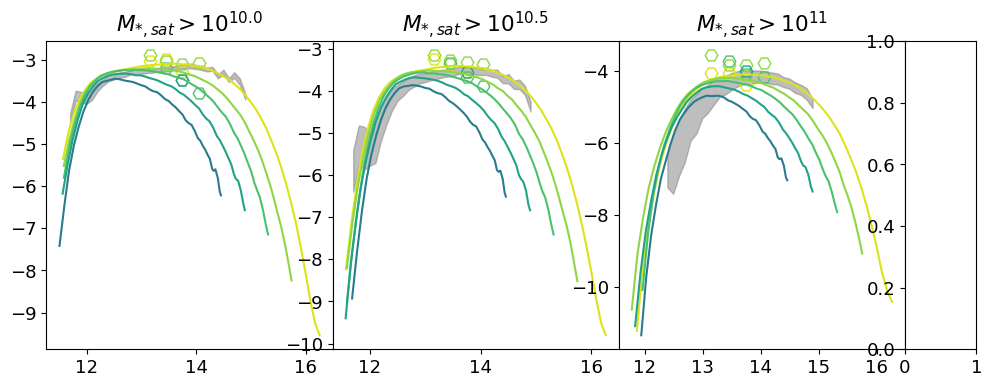

[0.15, 0.5, 0.85, 1.25, 1.75]


In [163]:
def CMD_wrap(M, z):
    return np.log10((massdefs.changeMassDefinitionCModel(M=M*h, z=z, mdef_in='200c', mdef_out='vir')[0])/Cosmo.h)

AvaHaloMass, z, AnalyticalModelFrac_highz, AnalyticalModelNoFrac_highz, SM_Cuts = F.LoadData_Sat_Env_Highz(('1.0', True, True, True, 'G19_DPL', 'G19_SE'))
SM_Cuts_Plt = [10.0, 10.5, 11] # use this to pick SM_Cut to plot

AvaHaloMassBins = AvaHaloMass[:,1:] - AvaHaloMass[:,:-1] 
AvaHaloMassBins = np.concatenate((AvaHaloMassBins, np.array([AvaHaloMassBins[:,-1]]).T), axis = 1)

fig = plt.figure(figsize=[12, 4])
gs = GridSpec(4, 13, hspace=0.0,wspace=0.0,figure=fig)
ax1 = fig.add_subplot(gs[0:4, 0:4])
ax2 = fig.add_subplot(gs[0:4, 4:8])
ax3 = fig.add_subplot(gs[0:4, 8:12])
ColorBar = fig.add_subplot(gs[0:4, 12:13])
SubPlots_NF = [ax1,ax2,ax3]
Redshifts = []


#Adding Marc HC COSMOS
File = fits.open(AbsPath+"/Data/Observational/M_HC_COSMOS/COSMOS_forFrancesco.fit")
df = table.Table(File[1].data).to_pandas()
df.HMASS = (df.HMASS-2*np.log10(0.72))+2*np.log10(h) #h correction
df['mvir'] = np.vectorize(CMD_wrap)(np.power(10, df.HMASS), np.array(df.ZPHOT)) #200c to vir correction

df.MSTAR = df.MSTAR -2*np.log10(0.72) + 2*np.log10(h) + 0.15 #h correction and bruzual and charlot correction
df_cen = df[df.CENTRAL == 1].copy()
df_sat = df[df.CENTRAL == 0].copy()
df_sat = df_sat[df_sat.HMASS>0].copy()

def Get_Sat_Rich(M_Central_Halo, M_Central_Gal, M_Cut):
    Table = df_sat[df_sat.HMASS == M_Central_Halo]
    N = len(Table[Table.MSTAR > M_Cut])
    if np.any(Table.MSTAR > M_Central_Gal) and (M_Central_Gal < M_Cut):
        return N - 1
    else:
        return N 

def Get_Sat_Mass(M_Central):
    Table = df_sat[df_sat.HMASS == M_Central]
    M = np.sum(np.power(10, Table.MSTAR))
    return np.log10(M)
def Get_MaxSat_Mass(M_Central):    
    Table = df_sat[df_sat.HMASS == M_Central]
    return np.max(Table.MSTAR)


df_cen['NSat_ten'] = np.vectorize(Get_Sat_Rich)(np.array(df_cen.HMASS), np.array(df_cen.MSTAR), 10)
df_cen['NSat_tpf'] = np.vectorize(Get_Sat_Rich)(np.array(df_cen.HMASS), np.array(df_cen.MSTAR), 10.5)
df_cen['NSat_ele'] = np.vectorize(Get_Sat_Rich)(np.array(df_cen.HMASS), np.array(df_cen.MSTAR), 11)
df_cen['Total_Sat_Mass'] = np.vectorize(Get_Sat_Mass)(np.array(df_cen.HMASS))
df_cen['Max_Sat_Mass'] = np.vectorize(Get_MaxSat_Mass)(np.array(df_cen.HMASS))
hm_bins = np.arange(13, 15.5, 0.3)
z_bins = [0.0, 0.3, 0.7, 1.0, 1.5, 2.0]
df_cen = df_cen.assign(Bin_z=lambda x: pd.cut(x.ZPHOT, bins=z_bins)).assign(Bin_m=lambda x: pd.cut(x.mvir, bins=hm_bins))

for z_group in df_cen.groupby(['Bin_z']):
    z_ = round(z_group[0].mid, 2)
    colour = GetColour(z_)
    for hm_group in z_group[1].groupby(['Bin_m']):
        hm = round(hm_group[0].mid, 2)
        HM_wt = HMF_fun(hm+np.log10(h), z_)[0]*hm_group[0].length*h_3
        #print(hm_group)
        Sat_wt = np.log10(HM_wt*np.mean(hm_group[1]['NSat_ten'])/hm_group[0].length)
        SubPlots_NF[0].plot(hm, Sat_wt, 'H', color = colour, fillstyle = "none")
        Sat_wt = np.log10(HM_wt*np.mean(hm_group[1]['NSat_tpf'])/hm_group[0].length)
        SubPlots_NF[1].plot(hm, Sat_wt, 'H', color = colour, fillstyle = "none")
        Sat_wt = np.log10(HM_wt*np.mean(hm_group[1]['NSat_ele'])/hm_group[0].length)
        SubPlots_NF[2].plot(hm, Sat_wt, 'H', color = colour, fillstyle = "none")
    Redshifts.append(z_)
    
Redshifts.sort()
NewRedshifts = []
Skip = False
for i in range(len(Redshifts)-1):
    if Skip:
        Skip = False
    else:
        if (Redshifts[i+1] - Redshifts[i])/np.divide(Redshifts[i+1] + Redshifts[i],2) > 0.1:
            NewRedshifts.append(Redshifts[i])
        else:
            NewRedshifts.append(np.divide(Redshifts[i+1] + Redshifts[i],2))
            Skip = True
    NewRedshifts.append(Redshifts[-1])        


Redshift_Bins = np.digitize(NewRedshifts, bins = z)
for j, Cut in enumerate(SM_Cuts_Plt):
    SubPlots_NF[j].set_title("$M_{*, sat} > 10^{%s}$" %(Cut))
    X_SDSS, Y_SDSS = Add_SDSS.NoFracPlot(SubPlots_NF[j], SM_Cut = Cut)
    for i, z_ in enumerate(z):
        if np.any(i == Redshift_Bins):
            Data_ix = np.digitize(Cut, bins = SM_Cuts)-1
            X_Bin = np.digitize(X_SDSS[0], AvaHaloMass[i]- np.log10(h))
            Y_Model = np.divide(AnalyticalModelNoFrac_highz[Data_ix][i], AvaHaloMassBins[i])
            X, Y = F.Gauss_Scatt(AvaHaloMass[i, X_Bin:]- np.log10(h), Y_Model[X_Bin:], Scatt = 0.1)

            SubPlots_NF[j].plot(X-0.1, np.log10(Y), "-", color =  GetColour(z_))    

plt.show()

print(Redshifts)